# Arrythmia prediction on ECG data using CNN

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/arrythmia.gif)

The use of deep learning models in medical fields can help reduce error rates and increase the possibility of an earlier diagnosis for better treatement.

## Dataset

Data source: [Physionet's MIT-BIH Arrhythmia Dataset](https://physionet.org/content/mitdb/1.0.0/)

The signals in the dataset correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, MaxPool1D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [2]:
train = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/mitbih_train.csv',header=None)
test = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/mitbih_test.csv',header=None)

train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [3]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


The attribute values are almost in the same range.

## The classes

There are five classes in the dataset:

* 0 - Non-ecotic beats (normal beat)
* 1 - Supraventricular ectopic beats
* 2 - Ventricular ectopic beats
* 3 - Fusion beats
* 4 - Unknown beats

Count in each label: 
0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


<BarContainer object of 5 artists>

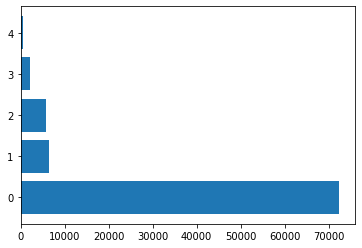

In [4]:
# The classes

label_names = ['Non-ecotic beats (normal beat)', 'Supraventricular ectopic beats', 'Ventricular ectopic beats', 'Fusion beats', 'Unknown beats']

labels = train[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

plt.barh(list(set(labels)), list(labels.value_counts()))

The dataset is very imbalanced.

The samples have to be separated into categories before resampling to provide a balanced dataset

In [5]:
# Separating the train dataframe into 5 individual ones based on class labels, and sampling 50000 from each.

train_lbl0 = resample(train[train[187]==0], replace=True, n_samples=50000, random_state=113)
train_lbl1 = resample(train[train[187]==1], replace=True, n_samples=50000, random_state=113)
train_lbl2 = resample(train[train[187]==2], replace=True, n_samples=50000, random_state=113)
train_lbl3 = resample(train[train[187]==3], replace=True, n_samples=50000, random_state=113)
train_lbl4 = resample(train[train[187]==4], replace=True, n_samples=50000, random_state=113)

In [6]:
# Concatenate the 5 dataframes into 1

train = pd.concat([train_lbl0, train_lbl1, train_lbl2, train_lbl3, train_lbl4])

labels = train[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

Count in each label: 
4    50000
3    50000
2    50000
1    50000
0    50000
Name: 187, dtype: int64


## Visualization

Text(0.5, 1.0, 'Non-ecotic beats (normal beat)')

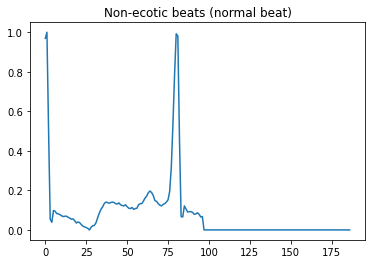

In [7]:
plt.plot(np.array(train_lbl0.sample(1))[0, :187])
plt.title(label_names[0])

Text(0.5, 1.0, 'Supraventricular ectopic beats')

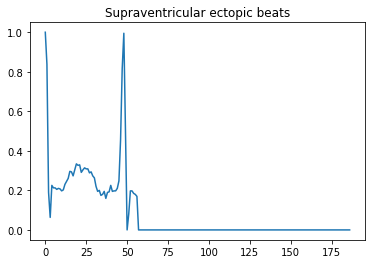

In [8]:
plt.plot(np.array(train_lbl1.sample(1))[0, :187])
plt.title(label_names[1])

Text(0.5, 1.0, 'Ventricular ectopic beats')

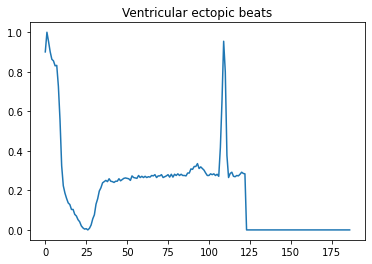

In [9]:
plt.plot(np.array(train_lbl2.sample(1))[0, :187])
plt.title(label_names[2])

Text(0.5, 1.0, 'Fusion beats')

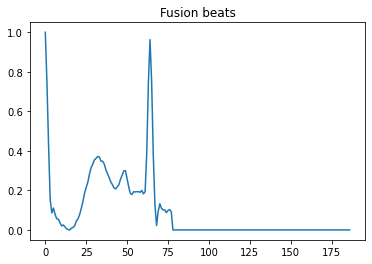

In [10]:
plt.plot(np.array(train_lbl3.sample(1))[0, :187])
plt.title(label_names[3])

Text(0.5, 1.0, 'Unknown beats')

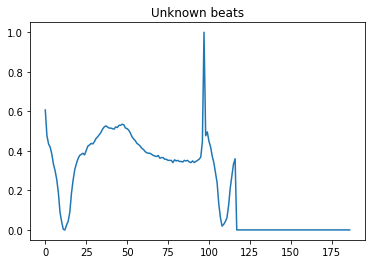

In [11]:
plt.plot(np.array(train_lbl4.sample(1))[0, :187])
plt.title(label_names[4])

## Preprocessing

In [12]:
# Adding some noise to increase efficiency of the trained model

def gaussian_noise(signal):
    noise = np.random.normal(0,0.05,187)
    return signal + noise

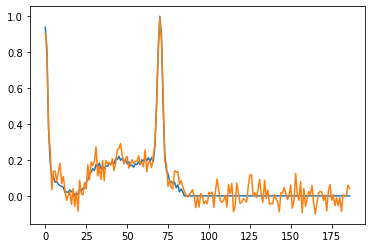

In [13]:
# Visualization with added noise

sample = train_lbl0.sample(1).values[0]

sample_with_noise = gaussian_noise(sample[:187])

plt.subplot(1, 1, 1)

plt.plot(sample[:187])
plt.plot(sample_with_noise)

In [14]:
# One hot encoding the output of the model

ytrain = keras.utils.to_categorical(train[187])
ytest = keras.utils.to_categorical(test[187])

# Input to the model
xtrain = train.values[:, :187]
xtest = test.values[:, :187]

# Adding noise
for i in range(xtrain.shape[0]):
    xtrain[i, :187] = gaussian_noise(xtrain[i, :187])

In [15]:
# Viewing the shapes

xtrain = np.expand_dims(xtrain, 2)
xtest = np.expand_dims(xtest, 2)

print("Shape of training data: ")
print("Input: ", xtrain.shape)
print("Output: ", ytrain.shape)

print("\nShape of test data: ")
print("Input: ", xtest.shape)
print("Output: ", ytest.shape)

Shape of training data: 
Input:  (250000, 187, 1)
Output:  (250000, 5)

Shape of test data: 
Input:  (21892, 187, 1)
Output:  (21892, 5)


## The model

In [16]:
model = Sequential()
model.add(Conv1D(64, 6, activation = 'relu', input_shape = xtrain[0].shape))
model.add(MaxPool1D(3, 2))

model.add(Conv1D(64, 6, activation = 'relu'))
model.add(MaxPool1D(3, 2))

model.add(Conv1D(64, 6, activation = 'relu'))
model.add(MaxPool1D(3, 2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer = keras.optimizers.Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
history = model.fit(xtrain, ytrain, epochs = 8, batch_size = 32, validation_data = (xtest, ytest))

Epoch 1/8
7813/7813 [==============================] - 108s 14ms/step - loss: 0.2340 - accuracy: 0.9151 - val_loss: 0.1796 - val_accuracy: 0.9357
Epoch 2/8
7813/7813 [==============================] - 112s 14ms/step - loss: 0.0948 - accuracy: 0.9666 - val_loss: 0.1598 - val_accuracy: 0.9535
Epoch 3/8
7813/7813 [==============================] - 109s 14ms/step - loss: 0.0675 - accuracy: 0.9761 - val_loss: 0.1396 - val_accuracy: 0.9591
Epoch 4/8
7813/7813 [==============================] - 105s 13ms/step - loss: 0.0545 - accuracy: 0.9811 - val_loss: 0.1479 - val_accuracy: 0.9573
Epoch 5/8
7813/7813 [==============================] - 104s 13ms/step - loss: 0.0471 - accuracy: 0.9835 - val_loss: 0.1369 - val_accuracy: 0.9614
Epoch 6/8
7813/7813 [==============================] - 104s 13ms/step - loss: 0.0417 - accuracy: 0.9858 - val_loss: 0.1419 - val_accuracy: 0.9619
Epoch 7/8
7813/7813 [==============================] - 105s 13ms/step - loss: 0.0375 - accuracy: 0.9871 - val_loss: 0.1451 -

## Plotting the metrics

In [18]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)

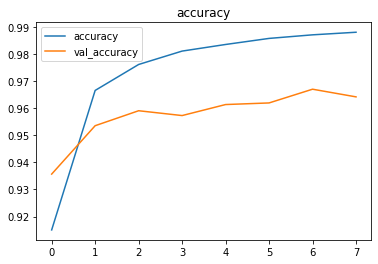

In [19]:
plot(history.history, "accuracy", "val_accuracy")

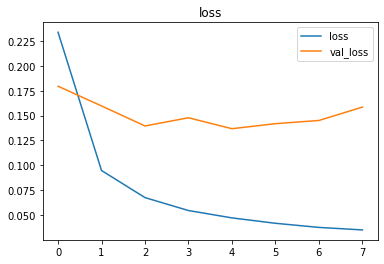

In [20]:
plot(history.history, "loss", "val_loss")

In [21]:
model.save('ecg_arryhtmia.h5')

## Model evaluation

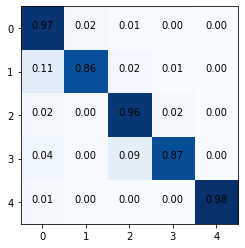

In [22]:
ypred = model.predict(xtest)

cm = confusion_matrix(ytest.argmax(axis=1), ypred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")


plt.imshow(cm, cmap=plt.cm.Blues)

Seems like our model is performing really well.

In [23]:
# Test data class labels spread

print("The distribution of test set labels")
print(test[187].value_counts())

print('F1_score = ', f1_score(ytest.argmax(axis=1), ypred.argmax(axis=1), average = 'macro'))

The distribution of test set labels
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64
F1_score =  0.8466146901279284


Given that our test set is imbalanced, the high f1-score indicates that our model has good performnace.

## Prediction

Actual label:  Non-ecotic beats (normal beat)
Model prediction :  Non-ecotic beats (normal beat)  with probability  0.99999964


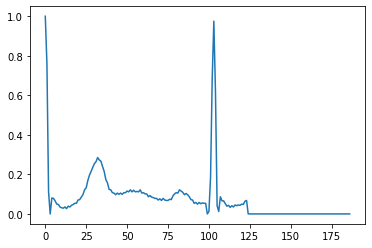

In [24]:
i = random.randint(0, len(xtest)-1)

output = model(np.expand_dims(xtest[i], 0))

pred = output.numpy()[0]

plt.plot(xtest[0])

print("Actual label: ", label_names[np.argmax(ytest[i])])
print("Model prediction : ", label_names[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])

## deepC

In [25]:
!deepCC ecg_arryhtmia.h5

reading [keras model] from 'ecg_arryhtmia.h5'
Saved 'ecg_arryhtmia.onnx'
reading onnx model from file  ecg_arryhtmia.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) conv1d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_2's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_2) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  ecg_arryhtmia_deepC/ecg_arryhtmia.cpp
INFO (ONNX): model files are ready in dir ecg_arryhtmia_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 ecg_arryhtmia_deepC/ecg_arryhtmia.cpp -o ecg_arryhtmia_deepC/ecg_arryhtmia.exe
Model executable  ecg_arryhtmia_deepC/ecg_arryhtmia.exe


reading file sample.data.
Error: conv1d_Relu_0_pooling: kernel shape is not given.
Error: tensor rank or axis not appropriate for Flatten operator.
Error: invalid tensor rank.
Error: invalid tensor rank.
Error: invalid tensor rank.
writing file dense_2.out.
Actual label:  Non-ecotic beats (normal beat)
Model prediction :  Supraventricular ectopic beats  with probability  0.291289


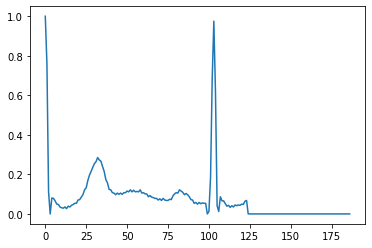

In [27]:
i = random.randint(0, len(xtest)-1)

np.savetxt('sample.data', (xtest[i]).flatten())  
    
!ecg_arryhtmia_deepC/ecg_arryhtmia.exe sample.data

pred = np.loadtxt('dense_2.out')

plt.plot(xtest[0])

print("Actual label: ", label_names[np.argmax(ytest[i])])
print("Model prediction : ", label_names[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])